# Data processing

In [81]:
%%capture
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
base_path='/kaggle/input/asl-fingerspelling/'

In [82]:
import warnings
warnings.filterwarnings("ignore","NumPy version", category=UserWarning)
import numpy as np 
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import re
from scipy.stats import skew, kurtosis


In [83]:
DEBUG = True

In [84]:
train_path=f'{base_path}/train.csv'
train = pd.read_csv(train_path).head(50) if DEBUG else pd.read_csv(file_path)
train

,path,file_id,sequence_id,participant_id,phrase
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road
5,train_landmarks/5414471.parquet,5414471,1817141095,38,www.freem.ne.jp
6,train_landmarks/5414471.parquet,5414471,1817169529,70,https://jsi.is/hukuoka
7,train_landmarks/5414471.parquet,5414471,1817171518,202,239613 stolze street
8,train_landmarks/5414471.parquet,5414471,1817195757,136,242-197-6202
9,train_landmarks/5414471.parquet,5414471,1817216847,93,271097 bayshore boulevard


In [85]:
train['phrase_char'] = train['phrase'].apply(tuple)
train['phrase_char_len'] = train['phrase_char'].apply(len)

train_sequence_id = train.set_index('sequence_id')

train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25


In [86]:
with open(base_path+'character_to_prediction_index.json') as json_file:
    CHAR2ORD = json.load(json_file)

CHAR2ORD_df=pd.Series(CHAR2ORD).to_frame('Ordinal Encoding')
print(type(CHAR2ORD),type(CHAR2ORD_df))

N_UNIQUE_CHARACTERS = len(CHAR2ORD)
print(f'CHAR2ORD: {CHAR2ORD}\nN_UNIQUE_CHARACTERS: {N_UNIQUE_CHARACTERS}')

def encode_phrase(phrase):
    # .get(char, -1): if the char doesn't exist in dict, return -1.
    return [CHAR2ORD.get(char, -1) for char in phrase]

train['ordinal_encoding'] = train['phrase'].apply(encode_phrase)

train.head()


<class 'dict'> <class 'pandas.core.frame.DataFrame'>
CHAR2ORD: {' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58}
N_UNIQUE_CHARACTERS: 59


,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]"
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5..."
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44..."
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45..."
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32..."


In [87]:
# Add complete file path to train
def get_file_path(path):
    return f'{base_path}{path}'

train['file_path'] = train['path'].apply(get_file_path)
train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5...",/kaggle/input/asl-fingerspelling/train_landmar...
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44...",/kaggle/input/asl-fingerspelling/train_landmar...
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45...",/kaggle/input/asl-fingerspelling/train_landmar...
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32...",/kaggle/input/asl-fingerspelling/train_landmar...


In [88]:
# Add phrase_type col
def get_phrase_type(phrase):
    if re.match(r'^[\d+-]+$', phrase):
        return 'phone_number'
    elif any([substr in phrase for substr in ['www', '.', '/']]) and ' ' not in phrase:
        return 'url'
    else:
        return 'address'
    
train['phrase_type'] = train['phrase'].apply(get_phrase_type)
train.head()

,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path,phrase_type
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address
1,train_landmarks/5414471.parquet,5414471,1816825349,107,scales/kuhaylah,"(s, c, a, l, e, s, /, k, u, h, a, y, l, a, h)",15,"[50, 34, 32, 43, 36, 50, 14, 42, 52, 39, 32, 5...",/kaggle/input/asl-fingerspelling/train_landmar...,url
2,train_landmarks/5414471.parquet,5414471,1816909464,1,1383 william lanier,"(1, 3, 8, 3, , w, i, l, l, i, a, m, , l, a, ...",19,"[16, 18, 23, 18, 0, 54, 40, 43, 43, 40, 32, 44...",/kaggle/input/asl-fingerspelling/train_landmar...,address
3,train_landmarks/5414471.parquet,5414471,1816967051,63,988 franklin lane,"(9, 8, 8, , f, r, a, n, k, l, i, n, , l, a, ...",17,"[24, 23, 23, 0, 37, 49, 32, 45, 42, 43, 40, 45...",/kaggle/input/asl-fingerspelling/train_landmar...,address
4,train_landmarks/5414471.parquet,5414471,1817123330,89,6920 northeast 661st road,"(6, 9, 2, 0, , n, o, r, t, h, e, a, s, t, , ...",25,"[21, 24, 17, 15, 0, 45, 46, 49, 51, 39, 36, 32...",/kaggle/input/asl-fingerspelling/train_landmar...,address


# Deal with landmarks files

In [89]:
def get_col_with_NaN(dataframe):
    has_nan = dataframe.isna().any()
    cols_with_nan = has_nan[has_nan].index.tolist()
    print(len(list(dataframe.iterrows())),',',len(cols_with_nan))
    print("Columns with NaN values:", cols_with_nan)
    
#get_col_with_NaN(pd.read_parquet(train['file_path'][0]))

In [90]:
%%time
def process_landmarks(file_path,sequence_id, debug=False):
    landmarks = pd.read_parquet(file_path)
    landmarks = landmarks.loc[landmarks.index == seq_id]
#     print(landmarks)
#     return
    
    hand_cols_without_z = [col for col in landmarks.columns if ('left_hand' in col or 'right_hand' in col) and not col.startswith('z_')]
    landmarks = landmarks[['frame']+hand_cols_without_z]

    landmarks['sequence_id'] = sequence_id

    # Deal with NaN  (*problem: not sure which way to fill NaN is better)
    coordinate_cols = [col for col in landmarks.columns if col.startswith(('x_', 'y_'))]
    landmarks.loc[:, coordinate_cols] = landmarks[coordinate_cols].fillna(0.0)
    
    # Others..unfinished....
    # ...

    return landmarks


#processed_landmarks_list = [process_landmarks(file_path, debug=DEBUG) for file_path in tqdm(train['file_path'])]
processed_landmarks_list = []
for file_path, seq_id in tqdm(zip(train['file_path'], train['sequence_id'])):
    processed_landmarks = process_landmarks(file_path, seq_id, debug=DEBUG)
    processed_landmarks_list.append(processed_landmarks)
    
all_processed_landmarks = pd.concat(processed_landmarks_list, ignore_index=True)

0it [00:00, ?it/s]

CPU times: user 3min 12s, sys: 1min 53s, total: 5min 6s
Wall time: 3min 6s


In [91]:
all_processed_landmarks.head()

,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,x_left_hand_8,...,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,sequence_id
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1816796431
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1816796431
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1816796431


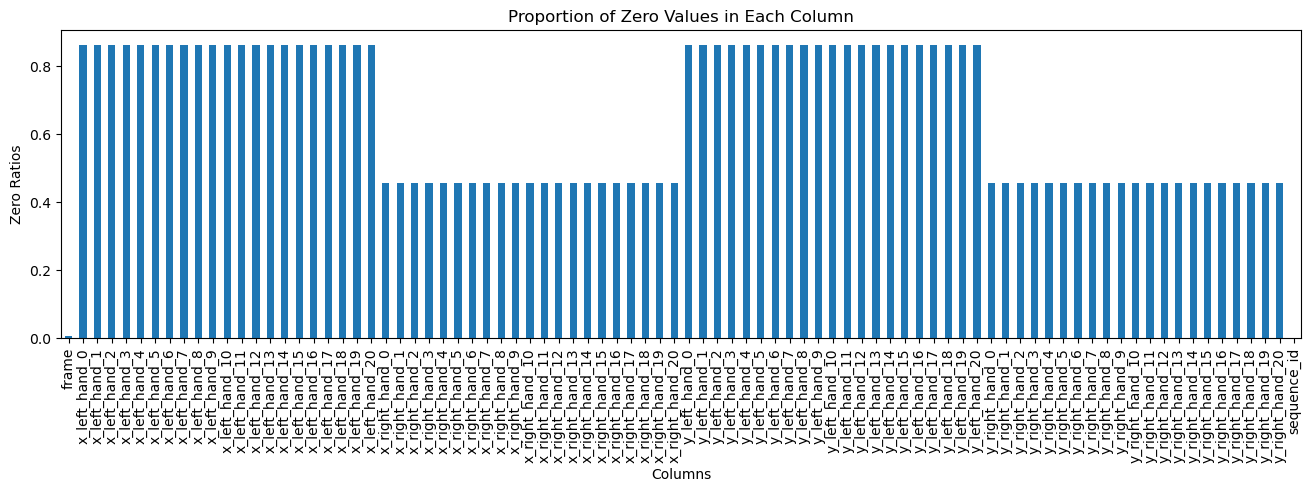

frame              0.005800
x_left_hand_0      0.864169
x_left_hand_1      0.864169
x_left_hand_2      0.864169
x_left_hand_3      0.864169
                     ...   
y_right_hand_17    0.457140
y_right_hand_18    0.457140
y_right_hand_19    0.457140
y_right_hand_20    0.457140
sequence_id        0.000000
Length: 86, dtype: float64

In [92]:
def zero_ratios_each_col(dataframe,IF_PLT=False):
    zero_ratios = (dataframe == 0).mean()

    if IF_PLT:
        plt.figure(figsize=(16, 4))
        zero_ratios.plot(kind='bar')
        plt.xlabel('Columns')
        plt.ylabel('Zero Ratios')
        plt.title('Proportion of Zero Values in Each Column')
        plt.show()

    return zero_ratios

zero_ratios_each_col(all_processed_landmarks,True)


In [93]:
# Get all kind of body part in landmarks
cols = all_processed_landmarks.columns

parts = set()

for col in cols:
    if '_' in col:
        part_name = '_'.join(col.split('_')[1:-1])
        if len(part_name)>0:
            parts.add(part_name)

parts_list = list(parts)
print(parts_list)

['right_hand', 'left_hand']


In [94]:
# %%time
# final_coordinates_list = []

# for row_index, frame in tqdm(all_processed_landmarks.iterrows()):
# #     if DEBUG and len(final_coordinates_list) >= 1000:
# #         break
#     for part_name in parts_list:
#         max_index = max(int(col.split('_')[-1]) for col in cols if f'x_{part_name}_' in col)
#         for index in range(max_index + 1):
#             temp_coordinates = {
#                 'sequence_id': int(frame['sequence_id']),
#                 'frame': int(frame['frame']),
#                 'part': part_name,
#                 'index': index,
#                 'x': frame[f'x_{part_name}_{index}'],
#                 'y': frame[f'y_{part_name}_{index}'],
#                 'z': frame[f'z_{part_name}_{index}'],
#             }
#             final_coordinates_list.append(temp_coordinates)

# new_df = pd.DataFrame(final_coordinates_list)

In [95]:
# # Just want to try--
# # Set MultiIndex
# new_df.set_index(['part', 'index'], inplace=True)

# print(new_df.loc[('right_hand', 20)])
# print(new_df.loc[('pose')].head())
# new_df.tail()

# new_df.reset_index(inplace=True)

In [96]:
# merged_df = pd.merge(train, new_df, on='sequence_id', how='left')

# #merged_df.query("part=='pose'")
# merged_df

# Merge Train and Landmarks

In [97]:
merged_df = pd.merge(train, all_processed_landmarks, on='sequence_id', how='left')

#print(', '.join(merged_df.columns))
merged_df.info()
merged_df

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8621 entries, 0 to 8620
Data columns (total 95 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   path              8621 non-null   object 
 1   file_id           8621 non-null   int64  
 2   sequence_id       8621 non-null   int64  
 3   participant_id    8621 non-null   int64  
 4   phrase            8621 non-null   object 
 5   phrase_char       8621 non-null   object 
 6   phrase_char_len   8621 non-null   int64  
 7   ordinal_encoding  8621 non-null   object 
 8   file_path         8621 non-null   object 
 9   phrase_type       8621 non-null   object 
 10  frame             8621 non-null   int16  
 11  x_left_hand_0     8621 non-null   float32
 12  x_left_hand_1     8621 non-null   float32
 13  x_left_hand_2     8621 non-null   float32
 14  x_left_hand_3     8621 non-null   float32
 15  x_left_hand_4     8621 non-null   float32
 16  x_left_hand_5     8621 non-null   float32


,path,file_id,sequence_id,participant_id,phrase,phrase_char,phrase_char_len,ordinal_encoding,file_path,phrase_type,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
0,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621
1,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930
4,train_landmarks/5414471.parquet,5414471,1816796431,217,3 creekhouse,"(3, , c, r, e, e, k, h, o, u, s, e)",12,"[18, 0, 34, 49, 36, 36, 42, 39, 46, 52, 50, 36]",/kaggle/input/asl-fingerspelling/train_landmar...,address,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,train_landmarks/5414471.parquet,5414471,1818246565,178,893-125-1663,"(8, 9, 3, -, 1, 2, 5, -, 1, 6, 6, 3)",12,"[23, 24, 18, 12, 16, 17, 20, 12, 16, 21, 21, 18]",/kaggle/input/asl-fingerspelling/train_landmar...,phone_number,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8617,train_landmarks/5414471.parquet,5414471,1818246565,178,893-125-1663,"(8, 9, 3, -, 1, 2, 5, -, 1, 6, 6, 3)",12,"[23, 24, 18, 12, 16, 17, 20, 12, 16, 21, 21, 18]",/kaggle/input/asl-fingerspelling/train_landmar...,phone_number,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8618,train_landmarks/5414471.parquet,5414471,1818246565,178,893-125-1663,"(8, 9, 3, -, 1, 2, 5, -, 1, 6, 6, 3)",12,"[23, 24, 18, 12, 16, 17, 20, 12, 16, 21, 21, 18]",/kaggle/input/asl-fingerspelling/train_landmar...,phone_number,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8619,train_landmarks/5414471.parquet,5414471,1818246565,178,893-125-1663,"(8, 9, 3, -, 1, 2, 5, -, 1, 6, 6, 3)",12,"[23, 24, 18, 12, 16, 17, 20, 12, 16, 21, 21, 18]",/kaggle/input/asl-fingerspelling/train_landmar...,phone_number,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [98]:
get_col_with_NaN(merged_df)

8621 , 0
Columns with NaN values: []


In [99]:
# Feature cols
features = merged_df.drop(columns=['ordinal_encoding','path','file_id','sequence_id','participant_id','phrase','phrase_char','file_path'])

# Label cols
labels = merged_df['ordinal_encoding']


features.shape,labels.shape
features

,phrase_char_len,phrase_type,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,...,y_right_hand_11,y_right_hand_12,y_right_hand_13,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20
0,12,address,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.490615,0.439064,0.680148,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621
1,12,address,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,12,address,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,12,address,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.528952,0.493427,0.667076,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930
4,12,address,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,12,phone_number,87,0.795680,0.694285,0.584999,0.493966,0.410174,0.632732,0.554647,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8617,12,phone_number,88,0.817987,0.692118,0.574779,0.480904,0.391680,0.631130,0.556394,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8618,12,phone_number,89,0.810021,0.692072,0.577193,0.484050,0.395327,0.636393,0.563244,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8619,12,phone_number,90,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [100]:
print(', '.join(features.columns))

phrase_char_len, phrase_type, frame, x_left_hand_0, x_left_hand_1, x_left_hand_2, x_left_hand_3, x_left_hand_4, x_left_hand_5, x_left_hand_6, x_left_hand_7, x_left_hand_8, x_left_hand_9, x_left_hand_10, x_left_hand_11, x_left_hand_12, x_left_hand_13, x_left_hand_14, x_left_hand_15, x_left_hand_16, x_left_hand_17, x_left_hand_18, x_left_hand_19, x_left_hand_20, x_right_hand_0, x_right_hand_1, x_right_hand_2, x_right_hand_3, x_right_hand_4, x_right_hand_5, x_right_hand_6, x_right_hand_7, x_right_hand_8, x_right_hand_9, x_right_hand_10, x_right_hand_11, x_right_hand_12, x_right_hand_13, x_right_hand_14, x_right_hand_15, x_right_hand_16, x_right_hand_17, x_right_hand_18, x_right_hand_19, x_right_hand_20, y_left_hand_0, y_left_hand_1, y_left_hand_2, y_left_hand_3, y_left_hand_4, y_left_hand_5, y_left_hand_6, y_left_hand_7, y_left_hand_8, y_left_hand_9, y_left_hand_10, y_left_hand_11, y_left_hand_12, y_left_hand_13, y_left_hand_14, y_left_hand_15, y_left_hand_16, y_left_hand_17, y_left_hand_

In [101]:
zero_ratios=zero_ratios_each_col(features)
zero_ratios.max()

0.8641688899199629

In [102]:
def remove_zero_cols(data,ratio=1.0):
    zero_ratios = (data == 0).mean()
    cols_to_remove = zero_ratios[zero_ratios >= ratio].index
    return data.drop(columns=cols_to_remove)

features_without_zero_cols = remove_zero_cols(features,1.0)
zero_ratios_each_col(features_without_zero_cols).info()

<class 'pandas.core.series.Series'>
Index: 87 entries, phrase_char_len to y_right_hand_20
Series name: None
Non-Null Count  Dtype  
--------------  -----  
87 non-null     float64
dtypes: float64(1)
memory usage: 1.4+ KB


In [103]:
features=features_without_zero_cols

# Continue to process dataset

In [104]:
from sklearn.preprocessing import OneHotEncoder

def do_OneHotEncoder(data, col):
    encoder = OneHotEncoder(sparse_output=False)

    phrase_type = data[col].values.reshape(-1, 1)

    phrase_type_onehot = encoder.fit_transform(phrase_type)
    phrase_type_onehot_df = pd.DataFrame(phrase_type_onehot, columns=encoder.get_feature_names_out(['phrase_type']))

    data = data.drop(columns=[col])
    data = pd.concat([data.reset_index(drop=True), phrase_type_onehot_df], axis=1)

    return data
    
features=do_OneHotEncoder(features,'phrase_type')
features.head()

,phrase_char_len,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,...,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,phrase_type_address,phrase_type_phone_number,phrase_type_url
0,12,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1.0,0.0,0.0
1,12,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,12,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
3,12,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1.0,0.0,0.0
4,12,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0


In [105]:
features

,phrase_char_len,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,...,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,phrase_type_address,phrase_type_phone_number,phrase_type_url
0,12,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.645134,0.697051,0.739250,0.728379,0.730378,0.770165,0.798621,1.0,0.0,0.0
1,12,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,12,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
3,12,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.677703,0.737446,0.783664,0.706994,0.722034,0.768912,0.799930,1.0,0.0,0.0
4,12,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,12,87,0.795680,0.694285,0.584999,0.493966,0.410174,0.632732,0.554647,0.500071,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0
8617,12,88,0.817987,0.692118,0.574779,0.480904,0.391680,0.631130,0.556394,0.507657,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0
8618,12,89,0.810021,0.692072,0.577193,0.484050,0.395327,0.636393,0.563244,0.509398,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0
8619,12,90,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0


In [106]:
def find_cols_maybe_need_to_normalize(data):
    cols_to_normalize = []
    numerical_cols = data.select_dtypes(include=np.number).columns
    for col in numerical_cols:
        min_val = data[col].min()
        max_val = data[col].max()
        if min_val < 0 or max_val > 1:
            cols_to_normalize.append(col)
    return cols_to_normalize

cols_to_normalize=find_cols_maybe_need_to_normalize(features)
print(cols_to_normalize)

['phrase_char_len', 'frame', 'x_left_hand_0', 'x_left_hand_1', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_17', 'y_left_hand_18', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_19', 'y_right_hand_20']


In [107]:
cols_to_normalize.remove('frame')
print(cols_to_normalize)

['phrase_char_len', 'x_left_hand_0', 'x_left_hand_1', 'x_left_hand_16', 'x_left_hand_17', 'x_left_hand_18', 'x_left_hand_19', 'x_left_hand_20', 'x_right_hand_16', 'x_right_hand_17', 'x_right_hand_18', 'x_right_hand_19', 'x_right_hand_20', 'y_left_hand_17', 'y_left_hand_18', 'y_right_hand_15', 'y_right_hand_16', 'y_right_hand_19', 'y_right_hand_20']


In [108]:
from sklearn.preprocessing import MinMaxScaler

# Normalize dataset
def normalize_cols(data,cols_to_normalize):
    scaler = MinMaxScaler()
    
    data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])
    return data
normalize_cols(features,cols_to_normalize)
features

,phrase_char_len,frame,x_left_hand_0,x_left_hand_1,x_left_hand_2,x_left_hand_3,x_left_hand_4,x_left_hand_5,x_left_hand_6,x_left_hand_7,...,y_right_hand_14,y_right_hand_15,y_right_hand_16,y_right_hand_17,y_right_hand_18,y_right_hand_19,y_right_hand_20,phrase_type_address,phrase_type_phone_number,phrase_type_url
0,0.181818,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.645134,0.692655,0.732771,0.728379,0.730378,0.759568,0.785157,1.0,0.0,0.0
1,0.181818,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
2,0.181818,2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
3,0.181818,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.677703,0.732795,0.776795,0.706994,0.722034,0.758332,0.786444,1.0,0.0,0.0
4,0.181818,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8616,0.181818,87,0.717480,0.673860,0.584999,0.493966,0.410174,0.632732,0.554647,0.500071,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0
8617,0.181818,88,0.737595,0.671757,0.574779,0.480904,0.391680,0.631130,0.556394,0.507657,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0
8618,0.181818,89,0.730412,0.671712,0.577193,0.484050,0.395327,0.636393,0.563244,0.509398,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0
8619,0.181818,90,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.0,0.0


In [109]:
features['phrase_char_len'].min()

0.0

In [110]:
features_save=features.copy()
# features=features_save.copy()
labels_save=labels.copy()
# labels_save

In [111]:
type(labels)

pandas.core.series.Series

In [112]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

ordinal_encoding = labels.tolist()

padded_sequences_labels = pad_sequences(ordinal_encoding, padding='post')

labels = np.array(padded_sequences_labels)
labels

array([[18,  0, 34, ...,  0,  0,  0],
       [18,  0, 34, ...,  0,  0,  0],
       [18,  0, 34, ...,  0,  0,  0],
       ...,
       [23, 24, 18, ...,  0,  0,  0],
       [23, 24, 18, ...,  0,  0,  0],
       [23, 24, 18, ...,  0,  0,  0]], dtype=int32)

# Train model 1 -- Transformer

https://www.tensorflow.org/text/tutorials/transformer

In [113]:
VOCAB_SIZE = N_UNIQUE_CHARACTERS
NUM_LAYERS = 4
UNITS = 512
D_MODEL = 128
NUM_HEADS = 8
DROPOUT = 0.1
EPOCHS = 10
BATCH_SIZE = 64

In [114]:
import logging
import time

import tensorflow_datasets as tfds
import tensorflow as tf

import tensorflow_text

In [125]:
X=features.copy()
y=labels.copy()

In [117]:
from sklearn.utils import shuffle

X,y=shuffle(X,y)
X,y

(      phrase_char_len  frame  x_left_hand_0  x_left_hand_1  x_left_hand_2  \
 3677         0.545455    148            0.0            0.0            0.0   
 4406         0.181818    161            0.0            0.0            0.0   
 4733         1.000000    123            0.0            0.0            0.0   
 3875         0.318182     73            0.0            0.0            0.0   
 8192         0.727273    134            0.0            0.0            0.0   
 ...               ...    ...            ...            ...            ...   
 2109         0.863636     50            0.0            0.0            0.0   
 2968         0.318182    151            0.0            0.0            0.0   
 7421         0.818182    158            0.0            0.0            0.0   
 8455         0.500000     96            0.0            0.0            0.0   
 5620         0.181818     28            0.0            0.0            0.0   
 
       x_left_hand_3  x_left_hand_4  x_left_hand_5  x_left_han

In [118]:
# from_tensor_slices: https://note.com/mlai/n/n64ca144365ac
train_size = int(0.8 * len(y))  # Split train val sets

train_dataset = tf.data.Dataset.from_tensor_slices((X, y)).take(train_size)
val_dataset = tf.data.Dataset.from_tensor_slices((X, y)).skip(train_size)
train_dataset,val_dataset

(<_TakeDataset element_spec=(TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(30,), dtype=tf.int32, name=None))>,
 <_SkipDataset element_spec=(TensorSpec(shape=(89,), dtype=tf.float64, name=None), TensorSpec(shape=(30,), dtype=tf.int32, name=None))>)

In [127]:
train_batches = train_dataset.shuffle(10000).batch(BATCH_SIZE)
val_batches = val_dataset.shuffle(10000).batch(BATCH_SIZE)
train_batches,val_batches

(<_BatchDataset element_spec=(TensorSpec(shape=(None, 89), dtype=tf.float64, name=None), TensorSpec(shape=(None, 30), dtype=tf.int32, name=None))>,
 <_BatchDataset element_spec=(TensorSpec(shape=(None, 89), dtype=tf.float64, name=None), TensorSpec(shape=(None, 30), dtype=tf.int32, name=None))>)

In [120]:
for X, y in train_dataset.take(2):  # Take n samples
    print('X shape: ',X.shape,'y shape: ',y.shape)
    print("X:", X.numpy())
    print("Y:", y.numpy())

X shape:  (89,) y shape:  (30,)
X: [  0.54545455 148.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.33940279   0.41467917
   0.47536671   0.49729261   0.47616774   0.39323327   0.39099869
   0.38985401   0.38620698   0.34018713   0.35538593   0.40600505
   0.43643504   0.2981655    0.32161379   0.38091746   0.4830778
   0.40961298   0.42705323   0.46933427   0.51505516   0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.62903583   0.60361612   0.57056683   0.54473907   0.52753651
   0.49262059   0.43522441   0.40040559   0.37094152   0.50236142
   0.46570063   0.49299818   0.5231958    0.5220

In [ ]:
from sklearn.model_selection import train_test_split

X=features.copy()
y=labels.copy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!apt install --allow-change-held-packages libcudnn8="8.4.0.27-1+cuda11.6"
!pip install --upgrade pip
!pip install -U "jax[cuda11_cudnn82]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

In [ ]:
# Check if successfully installed
!dpkg -l | grep libcudnn8

In [ ]:
!pip install numpy --upgrade

In [ ]:
!pip uninstall -y -q tensorflow keras tensorflow-estimator tensorflow-text
!pip install protobuf~=3.20.3
!pip install -q tensorflow_datasets
!pip install -q -U tensorflow-text tensorflow

# Train model 2 -- LSTM